# Setting up the notebook and realtive paths

In [1]:
# Discover repo root and read all CSV files from the per-series folders
from pathlib import Path
import pandas as pd

# Find repo root (stop at folder containing pyproject.toml or .git)
repo_root = Path.cwd()
for candidate in [repo_root] + list(repo_root.parents):
    if (candidate / 'pyproject.toml').exists() or (candidate / '.git').exists():
        repo_root = candidate
        break
print('Repo root:', repo_root)

wiertsema_dir = repo_root / 'output_data' / 'only_csv_wiertsema'
fugro_dir = repo_root / 'output_data' / 'only_csv_fugro'
# Directory containing meteorological/stressor CSVs
stressor_dir = repo_root / 'input_stressors'
# Explicit stressor file paths used elsewhere in notebooks
precip_path = stressor_dir / 'Neerslag_2021_2025.csv'
evap_path = stressor_dir / 'Verdamping_2021_2025.csv'

out_fig = repo_root / 'output_data' / 'figures'
out_fig.mkdir(parents=True, exist_ok=True)

print('wiertsema_dir ->', wiertsema_dir)
print('fugro_dir    ->', fugro_dir)
print('precip_path ->', precip_path)
print('evap_path  ->', evap_path)

Repo root: d:\Users\jvanruitenbeek\data_validation
wiertsema_dir -> d:\Users\jvanruitenbeek\data_validation\output_data\only_csv_wiertsema
fugro_dir    -> d:\Users\jvanruitenbeek\data_validation\output_data\only_csv_fugro
precip_path -> d:\Users\jvanruitenbeek\data_validation\input_stressors\Neerslag_2021_2025.csv
evap_path  -> d:\Users\jvanruitenbeek\data_validation\input_stressors\Verdamping_2021_2025.csv


# Loading in the precipitation and evap file

Based on data with the "." seperator

In [2]:
# Single-line load per file (no try/except):
df_prec = (
    pd.read_csv(precip_path, index_col=0, parse_dates=True,
                encoding='utf-8-sig', encoding_errors='replace')
    if precip_path.exists() else None
)

df_evap = (
    pd.read_csv(evap_path, index_col=0, parse_dates=True, sep=';', decimal=',', 
                encoding='utf-8-sig', encoding_errors='replace')
    if evap_path.exists() else None
)

C:\Users\jvanruitenbeek\AppData\Local\Temp\103\ipykernel_47668\3421066653.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(precip_path, index_col=0, parse_dates=True,


For different dataset based on hourly data with the ";" and "," seperators

In [3]:
df_prec = (
    pd.read_csv(
        precip_path,
        sep=";",              # <-- semicolon-delimited file
        decimal=",",          # <-- comma decimals (e.g., 0,05)
        index_col=0,
        parse_dates=[0],      # parse the first column as datetime
        dayfirst=True,        # because '1-01-21 0:00' is D-M-YY
        # date_format="%d-%m-%y %H:%M",  # (optional) faster & stricter
        encoding="utf-8-sig",
        encoding_errors="replace",
    )
    if precip_path.exists() else None
)


df_evap = (
    pd.read_csv(
        evap_path,
        sep=";",              # <-- semicolon-delimited file
        decimal=",",          # <-- comma decimals (e.g., 0,05)
        index_col=0,
        parse_dates=[0],      # parse the first column as datetime
        dayfirst=True,        # because '1-01-21 0:00' is D-M-YY
        # date_format="%d-%m-%y %H:%M",  # (optional) faster & stricter
        encoding="utf-8-sig",
        encoding_errors="replace",
    )
    if precip_path.exists() else None
)

C:\Users\jvanruitenbeek\AppData\Local\Temp\103\ipykernel_47668\2441692384.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(


<Axes: xlabel='timestamp'>

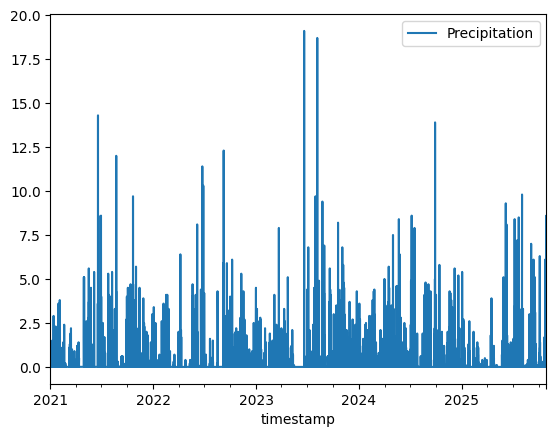

In [4]:
# Bestand is van het KNMI, neerslag in 0.1 mm dus omzetten naar mm
df_prec_mm = df_prec / 10
df_prec_mm.plot()

# Creating loop to merge files

In [5]:
from pathlib import Path
import pandas as pd

# --- Option A: Manually specify the exact Wiertsema CSV file you want ---
# Set this to the filename (not full path) or to None to use the interactive picker below
manual_filename = 'NL-241417-ET-21120911_B14-PB1_-4.95_-5.95_m_NAP_avg.csv'  # <-- change as needed or set to None

csv_file_dir = repo_root / 'output_data' / 'only_csv_fugro' / manual_filename

# Read (first col = datetime index)
head_csv_file = pd.read_csv(csv_file_dir,
    index_col=0, parse_dates=True, encoding="utf-8-sig", encoding_errors="replace"
)

# Ensure numeric (in case of commas/strings) before resampling
for c in head_csv_file.columns:
    head_csv_file[c] = pd.to_numeric(head_csv_file[c], errors="coerce")

# # Optional resample to hourly mean + align to the same daily index as df_evap / df_prec
head_csv_file = head_csv_file.resample("h").mean()

# Choose a reference daily index (df_evap expected to be defined earlier)
ref_index = df_evap.index
head_csv_file = head_csv_file.reindex(ref_index)

# Merge on shared daily index
merged = pd.concat([df_prec_mm.reindex(ref_index), df_evap.reindex(ref_index), head_csv_file], axis=1)

# rename column at positional index 2 to "head"
if merged.shape[1] > 2:
    merged = merged.rename(columns={merged.columns[2]: "head"})


In [6]:
merged = merged.copy()

# (optional) make sure the three inputs are numeric
for col in ["Precipitation", "Evapotranspiration", "head"]:
    merged[col] = pd.to_numeric(merged[col], errors="coerce")

# Recharge = P - ET  (can be negative when ET > P)
merged["recharge"] = merged["Precipitation"] - merged["Evapotranspiration"]

# Change in head vs previous timestamp: positive => rising, negative => falling
merged["head_t1"] = merged["head"].diff()

In [7]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42264 entries, 2021-01-01 00:00:00 to 2025-10-27 23:00:00
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Precipitation       42264 non-null  float64
 1   Evapotranspiration  42264 non-null  float64
 2   head                16697 non-null  float64
 3   recharge            42264 non-null  float64
 4   head_t1             16692 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


# Creating a plot to view the data

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_water_balance(merged, title="Water balance and head"):
    """
    Plot precipitation, evapotranspiration, recharge (bars, normal y)
    and head (line, secondary y), clipped to the first non-NaN head value.
    """

    # Find first valid head date and clip
    first_head_idx = merged["head"].first_valid_index()
    if first_head_idx is not None:
        data = merged.loc[first_head_idx:]
    else:
        data = merged

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Bars on the primary y-axis (normal orientation: positive up, negative down)
    fig.add_bar(
        name="Precipitation",
        x=data.index,
        y=data["Precipitation"],
        opacity=0.6,
        marker_line_width=0,
    )
    fig.add_bar(
        name="Evapotranspiration",
        x=data.index,
        y=data["Evapotranspiration"],
        opacity=0.6,
        marker_line_width=0,
    )
    fig.add_bar(
        name="Recharge",
        x=data.index,
        y=data["recharge"],
        opacity=0.6,
        marker_line_width=0,
        marker=dict(color="purple"),  # Recharge in purple
    )

    # Line on the secondary y-axis (head)
    fig.add_trace(
        go.Scatter(
            name="Head",
            x=data.index,
            y=data["head"],
            mode="lines",
            line=dict(width=1.5, color="black"),
        ),
        secondary_y=True,
    )

    fig.update_layout(
        title=title,
        barmode="overlay",  # or "group"
        hovermode="x unified",
        template="plotly_white",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
            x=0,
        ),
        margin=dict(t=40, r=20, b=40, l=60),
    )

    # Primary y-axis: normal (no inversion)
    fig.update_yaxes(
        title_text="Precipitation / Evapotranspiration / Recharge",
        secondary_y=False,
    )

    # Secondary y-axis for head
    fig.update_yaxes(
        title_text="Head",
        secondary_y=True,
    )

    return fig

In [17]:

# Usage:
fig = plot_water_balance(merged)
fig.show()